In [207]:
import numpy as npb
from matplotlib import pyplot as plt
import numpy as np

from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import pandas as pd

In [142]:
class Backtest:
    def __init__(self,data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        print(f"Cummulative return is: {res:.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")

    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        print(f"Max Drawdown: {res:.2f}%")
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        print(f"Sharpe Ratio: {res:.3f}")

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        print(f"Strategy CAGR is: {CAGR:.2f}%")
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Asset Return")
        ax.legend(["Asset Cumm Return","Strategy Cumm Return (Adj)"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
        self.calculate_cumm_return()
        self.calculate_cagr()
        self.calculate_max_drawdown()
        self.calculate_sharpe_ratio()
        self.plot_backtest_buy_sell()
        self.plot_backtest_returns()

# Example to use this code:

## Generate Signal on Backtest data

#### MACD

In [167]:
MACD_data = pdr.get_data_yahoo('SPY',start="2004-11-1", end="2023-11-1")
EMA_12=MACD_data['Adj Close'].ewm(span=12,min_periods=12,adjust=False).mean()
EMA_26=MACD_data['Adj Close'].ewm(span=26,min_periods=12, adjust=False).mean()
MACD= EMA_12- EMA_26
MACD_Signal=MACD.ewm(span=9,min_periods=9,adjust=False).mean()
MACD_data['Position']=np.where(MACD>MACD_Signal,1,np.where(MACD<MACD_Signal,-1,0))

[*********************100%***********************]  1 of 1 completed


In [168]:
MACD_data

,Open,High,Low,Close,Adj Close,Volume,Position
Date,,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617943,36720900,0
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645630,56210000,0
2004-11-03,115.029999,115.360001,114.239998,114.980003,79.636093,76960200,0
2004-11-04,114.779999,116.669998,114.680000,116.550003,80.723473,55350300,0
2004-11-05,117.050003,117.639999,116.489998,117.279999,81.229065,63287200,0
...,...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,-1
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,-1
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,-1


Cummulative return is: 411.01% with final Account balance: $511010.01513891574
Strategy CAGR is: 8.96%
Max Drawdown: -55.19%
Sharpe Ratio: 0.542


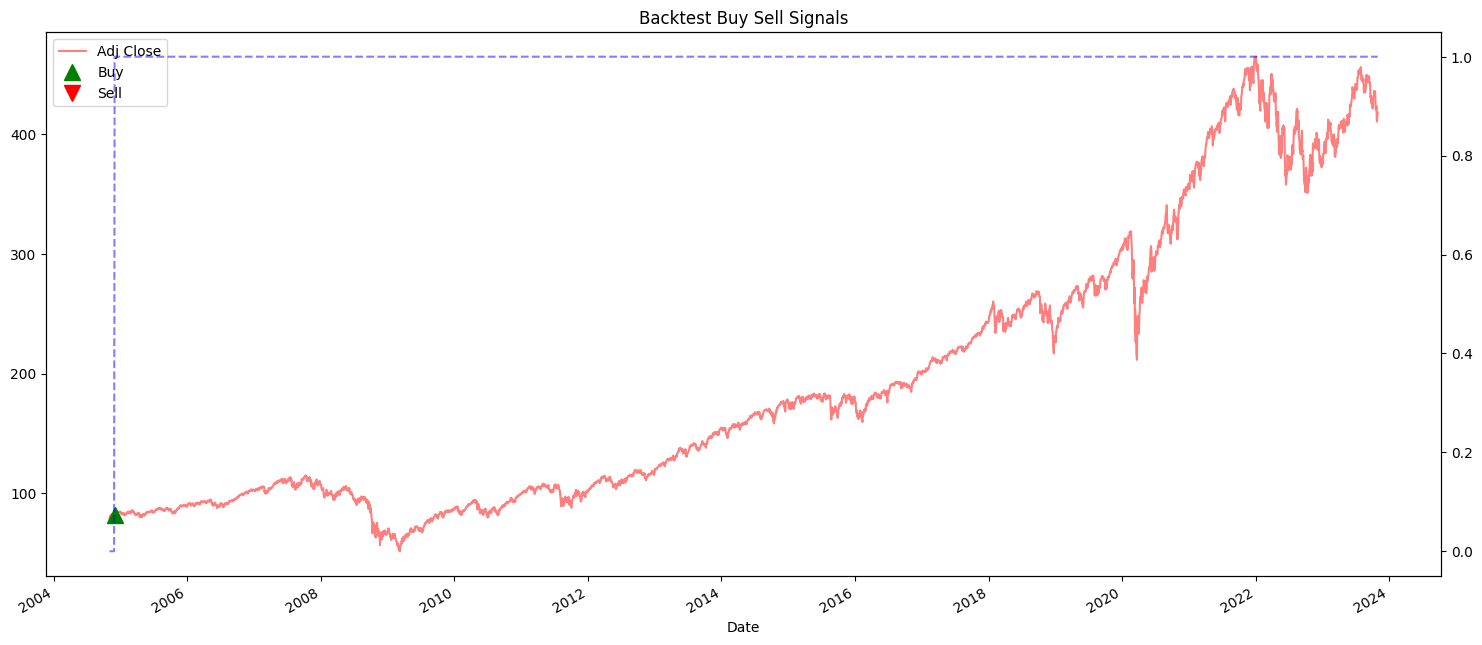

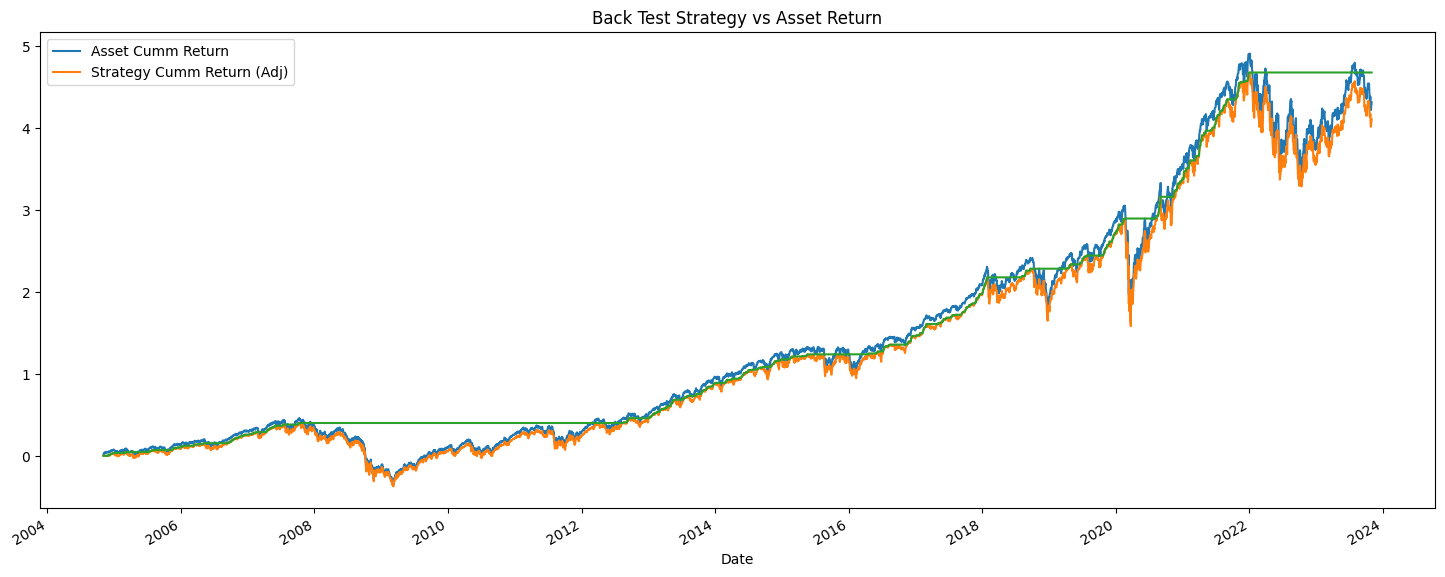

In [208]:
Backtest_MACD_Crossover_Strategy=Backtest(MACD_data,100000,0)
Backtest_MACD_Crossover_Strategy.plot_all_stats()

#### Baseline

In [175]:
SnpBase_data=pdr.get_data_yahoo('SPY',start="2004-11-1", end="2023-11-1")
SnpBase_data['Position']=1

[*********************100%***********************]  1 of 1 completed


In [212]:
Backtest_SnPBase_Strategy=Backtest(SnpBase_data,100000,0)
Backtest_SnPBase_Strategy.plot_all_stats()

KeyError: 'Position'

#### 200 Day Moving Average

In [186]:
MA200_data = pdr.get_data_yahoo('SPY',start="2004-11-1", end="2023-11-1")
MA200_Signal = MA200_data['Adj Close'].rolling(window=200).mean()
MA200_data['Position']=np.where(MA200_data['Adj Close']>MA200_Signal,1,0)

[*********************100%***********************]  1 of 1 completed


Cummulative return is: 236.35% with final Account balance: $336352.4397591024
Strategy CAGR is: 6.59%
Max Drawdown: -20.68%
Sharpe Ratio: 0.621


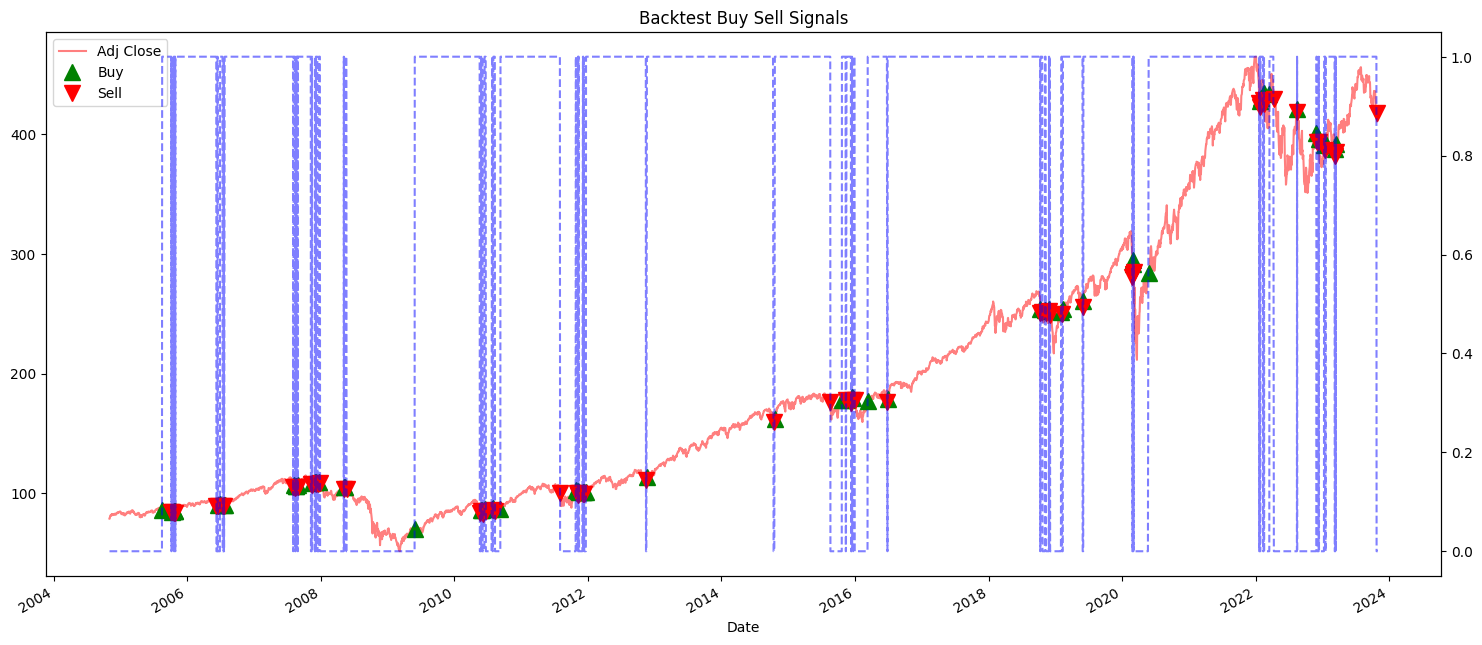

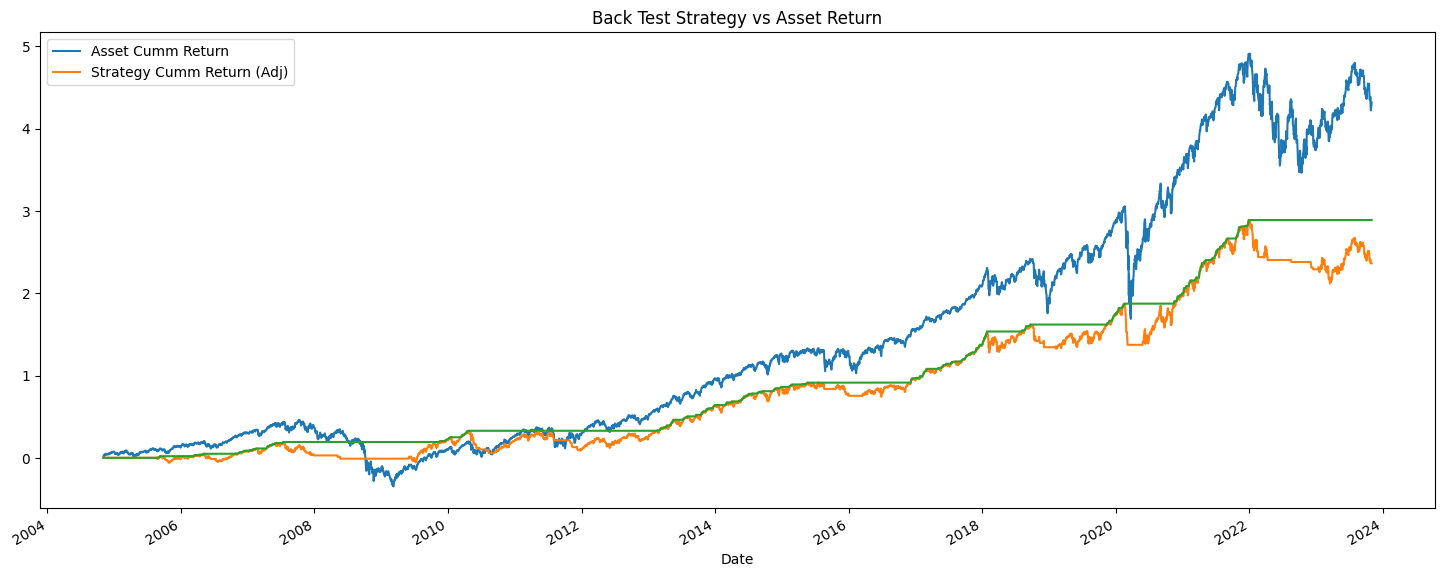

In [187]:
Backtest_MA200_Strategy=Backtest(MA200_data,100000,0)
Backtest_MA200_Strategy.plot_all_stats()

In [196]:
def RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

In [199]:
MeanRev_data=pdr.get_data_yahoo('SPY',start="2004-11-1", end="2023-11-1")


[*********************100%***********************]  1 of 1 completed


In [200]:
MeanRev_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617950,36720900
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645622,56210000
2004-11-03,115.029999,115.360001,114.239998,114.980003,79.636047,76960200
2004-11-04,114.779999,116.669998,114.680000,116.550003,80.723434,55350300
2004-11-05,117.050003,117.639999,116.489998,117.279999,81.229057,63287200
...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700


In [203]:
MeanRev_data['Score']=(MeanRev_data['Close']-MeanRev_data['Low'])/(MeanRev_data['High']-MeanRev_data['Low'])
MeanRev_data['Position']= np.where(MeanRev_data['Score']<0.2,1,0)

Cummulative return is: 327.73% with final Account balance: $427727.3873403455
Strategy CAGR is: 7.95%
Max Drawdown: -18.41%
Sharpe Ratio: 0.794


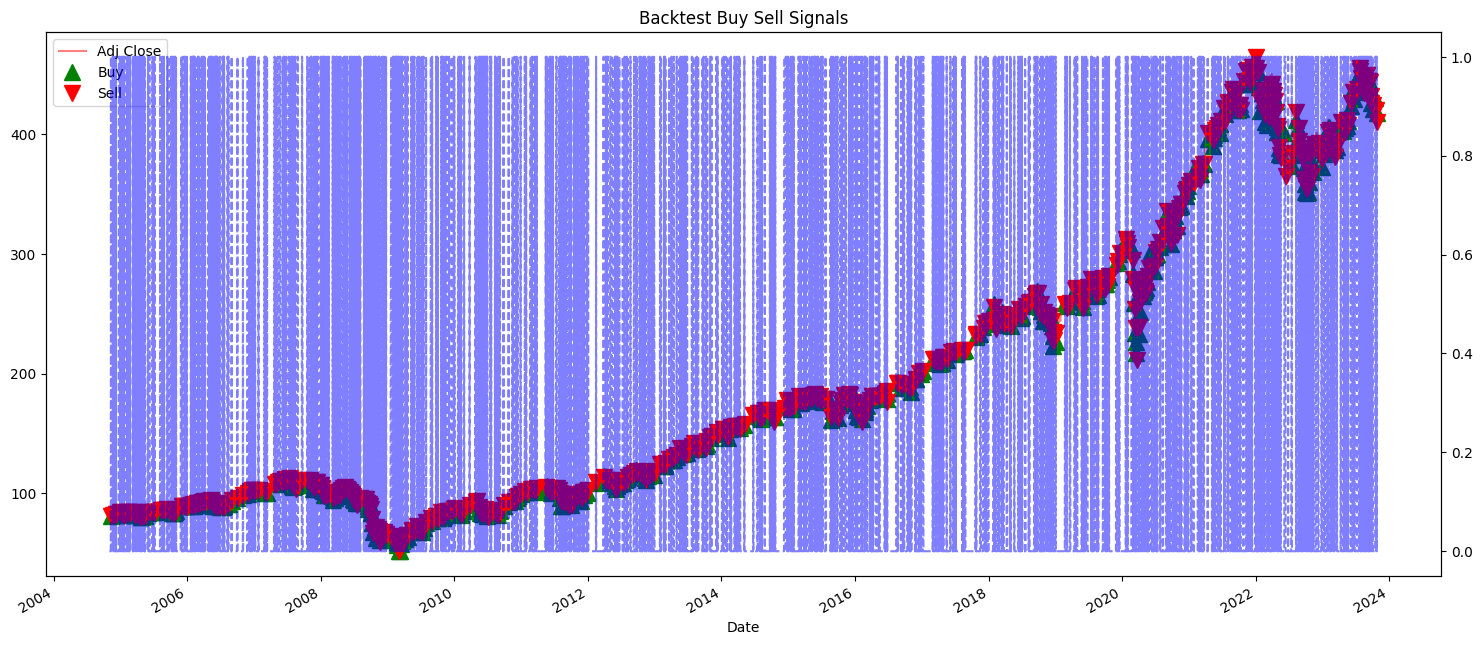

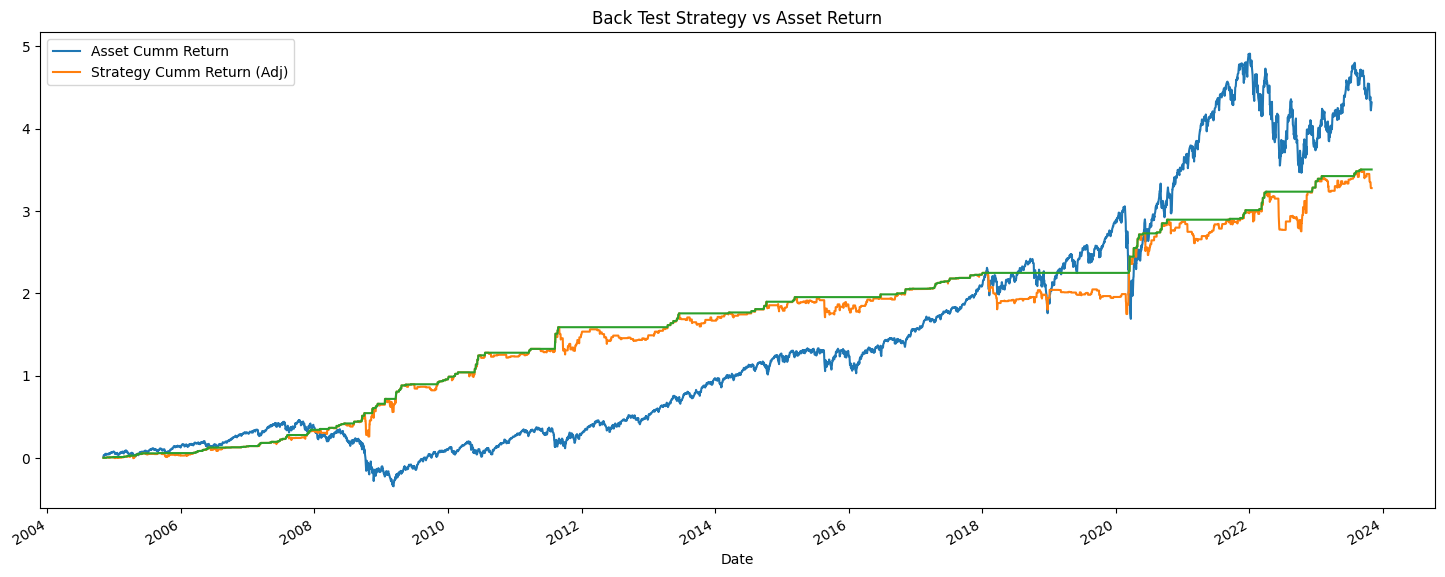

In [205]:
Backtest_MR_Strategy=Backtest(MeanRev_data,100000,0)
Backtest_MR_Strategy.plot_all_stats()

In [206]:
Backtest_MR_Strategy.data

,Open,High,Low,Close,Adj Close,Volume,Position,Score,Buy_Sell,log_return,Strategy_return,Expense,Capital,Adj Capital,Adj return,drawdown
Date,,,,,,,,,,,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617950,36720900,0,0.484384,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645622,56210000,0,0.244446,0.0,0.000352,0.000000,0,100000.000000,100000.000000,NaN,NaN
2004-11-03,115.029999,115.360001,114.239998,114.980003,79.636047,76960200,0,0.660718,0.0,0.012515,0.000000,0,100000.000000,100000.000000,0.000000,0.000000
2004-11-04,114.779999,116.669998,114.680000,116.550003,80.723434,55350300,0,0.939701,0.0,0.013562,0.000000,0,100000.000000,100000.000000,0.000000,0.000000
2004-11-05,117.050003,117.639999,116.489998,117.279999,81.229057,63287200,0,0.686956,0.0,0.006244,0.000000,0,100000.000000,100000.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,1,0.108162,1.0,-0.014456,-0.000000,0,434882.557095,434882.557095,0.000000,-0.034984
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,1,0.165791,0.0,-0.012047,-0.012047,0,429675.006265,429675.006265,-0.012047,-0.047031
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,0,0.272727,-1.0,-0.004543,-0.004543,0,427727.387340,427727.387340,-0.004543,-0.051574


In [214]:
SnpBase_data=pdr.get_data_yahoo('SPY',start="2004-11-1", end="2023-11-1")
SnpBase_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617920,36720900
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645630,56210000
2004-11-03,115.029999,115.360001,114.239998,114.980003,79.636101,76960200
2004-11-04,114.779999,116.669998,114.680000,116.550003,80.723480,55350300
2004-11-05,117.050003,117.639999,116.489998,117.279999,81.229065,63287200
...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700


In [217]:
SnpBase_data['return']=np.log(SnpBase_data['Adj Close']/SnpBase_data['Adj Close'].shift(1))

In [218]:
SnpBase_data['return'] = np.where(SnpBase_data['return']<0,0,SnpBase_data['return'])

In [219]:
SnpBase_data

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617920,36720900,NaN
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645630,56210000,0.000352
2004-11-03,115.029999,115.360001,114.239998,114.980003,79.636101,76960200,0.012515
2004-11-04,114.779999,116.669998,114.680000,116.550003,80.723480,55350300,0.013562
2004-11-05,117.050003,117.639999,116.489998,117.279999,81.229065,63287200,0.006244
...,...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200,0.000000
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800,0.000000
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700,0.000000


In [224]:
100000*np.exp(SnpBase_data['return'].sum())

27768523221894.973